<a href="https://colab.research.google.com/github/AdhirajChaddha/MNIST-Learning/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


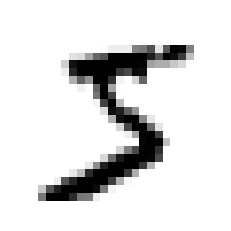

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

digit = X[0]
digit = digit.reshape(28, 28)

plt.imshow(digit, cmap='binary')
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

Lets start by crating a binary classifier that distinguishes between a 5 and not 5

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
# Lets create a vector that is true for all 5s and 
# false for all else
y_train_5 = y_train == '5'
print(y_train_5[:10])
y_test_5 = (y_test == '5')

[ True False False False False False False False False False]


In [7]:
# Lets then start by training a SGDClassifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [0]:
# This calssifier seems like a good one as ait achieves
# over 95% accuracy in all 3 validation folds. But, lets now
# create a classifier that classifies everything as false

from sklearn.base import 